# Homework: Autoencoding MNIST (and Celebrity Faces)


> **Due Date: February 27th, 2026 @ 1:00pm**
>
> Please turn in this completed notebook via Google classroom. Slack or email Alex or Vishvak if you run into any issues.

**Collaboration policy and more**

You're welcome (and highly encouraged) to work with and discuss this homework assignment with others in the class, and feel free to use any resources (textbooks, online notebooks, etc). The only requirement is that the final notebook that you turn in must be your own written work (no copy and pasting, please).

**Overview**

In class, we cover how Hinton and Salakhutdinov's 2006 Science Paper, ["Reducing the Dimensionality of Data with Neural Networks"](https://www.science.org/doi/10.1126/science.1127647) was one of the first demonstrations of unsupervised pretraining for use in training deep neural networks. In this homework, we'll implement autoencoders in the context of MNIST. Additionally, as an optional assignment, a similar architecture can be used for a subset of CelebA dataset of celebrity faces.


## Before you get started

**1) Background reading**

Please Read Hinton and Salakhutdinov's 2006 seminal work on deep autoencoders (https://www.science.org/doi/10.1126/science.1127647), as this notebook aims to recreate this important work. A few questions to think about as you read that will help you in this assignment:
  - What architecture do they use for their deep autoencoders?
  - Why were deep neural networks so much harder to train in 2006?

**2) How to run this notebook**

This Jupyter Notebook can be used in two ways:
* *Option 1: Download the notebook*

  We've included all the imports necessary for this homework. Please make sure you're running Python 3 with PyTorch (and Torchvision) installed and ready to go, along with NumPy and Matplotlib. Although you might find that these models train a bit faster on GPU, this homework assignment should be doable on most modern laptops. If you're having trouble please let us know ASAP.

* *Option 2: Run it online on Google Colaboratory*

  - Colab gives access to a GPU, so it could be useful in case you don't have CUDA installed on your computer (**Note: you can use this as an opportunity to get started on GPU training, but we recommend you develop your model and make sure everything works on CPU first**)
  - Make a copy of this notebook in your Google Drive folder: "File" -> "Save a copy in Drive..."
  - By default, Colab does not make GPUs available, but you can easily access them by selecting GPU in "Runtime" -> "Change runtime type..."
  - Remember that Colab runs in a temporary virtual machine, so all the data created while running the notebook will be lost at the end of the session, or when the runtime disconnects due to inactivity. To preserve data between sessions, there are a couple of options:
    * you can link Colab to your personal Google Drive by mounting it on your runtime, see first cell below.
    * you can download/upload files from the Files tab on the right sidebar.

**3) How to complete this assignment**

  - Fill out the relevant code blocks as indicated
  - Answer questions by writing them directly in the text block. Please keep your written answers concise, most are meant to be answered in a sentence or two.
  - Make figures showing your results and add comments with your observations.

**4) Optional exercise: CelebA Data**

Whereas MNIST is a toy dataset built into PyTorch, we can also examine a more complex feature space using a subset of 90,000 celebrity portraits from CelebA (see [Liu et al. (2014), "Deep Learning Face Attributes in the Wild"](https://arxiv.org/abs/1411.7766)). This is an optional part of the homework, but is a nice way to see how autoencoders perform on other types of visual data. There will be a .zip file of the relevant celebrity faces dataset on the Google Classroom link.

***Let's start!***

---

## Train an autoencoder on MNIST

The following command can be used to mount your personal Google Drive folder on the temporary virtual machine, so you can recover data between sessions (follow the instructions, you'll need an authorization code). Additional info [here](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA).


In [1]:
# # Skip this cell if running locally
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# Import all the necessary libraries
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

from IPython.display import Image, display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Using CUDA will make training be faster, but if you are working on your own computer without CUDA you can set `use_cuda = False` below.

If you are working on Colab, make sure to use a runtime with GPU ("Runtime" -> "Change runtime type" -> "{one of H100, A100, L4, T4} GPU").


You can check if CUDA is available on your local computer with: `torch.cuda.is_available()`

In [3]:
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
torch.manual_seed(168);

> **Question 0.1) Why is it important to set the seed for the random number generator?**
    np.random.seed(random_seed) takes the parameter value as the seed, then create a fixed set of "random" numbers every time based on the same random_seed. However, where the parameters is left blank, np.random.seed() set the seed to a random number, resulting in different set of random numbers. It is important to set the seed for the random number generator when the user would like the "random numbers" to be predictable, making it easier for debugging the code with them fixed.   

### 1. MNIST Dataset

As noted in class, MNIST has been widely used to benchmark new deep learning architectures and is already built into PyTorch. We provide this data as a starting point, again noting that the mean and std of the training set are calculated to be 0.1307 and 0.3081, respectively.

In [5]:
preprocessing = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(
    './bmi212_downloads', train=True, download=True,
    transform=preprocessing)

test_dataset = datasets.MNIST(
    './bmi212_downloads', train=False, download=True,
    transform=preprocessing)

In [6]:
print(train_dataset[0][0].size())
print(test_dataset[0][0].size())

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


In [7]:
print(len(test_dataset))
print(len(train_dataset))

10000
60000


> **Q1.1) How many examples do the training set and test set have?**
    training: 60,000. test: 10,000.
...

> **Q1.2) What's the format of each input example? Can we directly put these into a fully-connected layer?**
    Each input sample is a 1 by 28 by 28 picture of 28*28 (784) pixels. We cannot directly feed this into a fully-connected layer because it expects a 1D feature vector. The image must first be flattened into a 784-dimensional vector. 
...

> **Q1.3) Why do we normalize the input data for neural networks?**
    We normalize input data to ensure stable and faster training by keeping feature values in a similar scale, preventing large gradients, and improving optimization efficiency.
...

> **Q1.4) In this scenario, MNIST is already split into a training set and a test set. What is the purpose of dataset splitting (and specifically, the purpose of a test set)? For modern deep learning, a three-way split into training, validation, and test sets is usually preferred, why?**
    Dataset splitting ensures that we evaluate a model’s ability to generalize to unseen data. The training set is used to learn model parameters, while the test set provides an unbiased evaluation of final model performance.
    In modern deep learning, a validation set is introduced to tune hyperparameters and select models without contaminating the test set. This preserves the test set as a truly independent benchmark for final evaluation.
...

### 2. Using DataLoaders for MNIST

Set up the DataLoader objects below. Although the arguments are prepopulated, you may need to change the batch sizes or other arguments during training.

In [8]:
BATCH_SIZE = 128  # <-- Please change this as necessary
NUM_WORKERS = 1  # <-- Use more workers for more CPU threads

In [9]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS)

In [10]:
one_batch=next(iter(train_loader))
one_batch[0].size()

/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

torch.Size([128, 1, 28, 28])

> **Q2.1) It's recommended to shuffle the training data over each epoch, but this isn't typically the case for the test set, why?**
    By reshuffling each epoch, we ensure different sample groupings, providing better stochasticity and improving optimization stability. Test data does not require shuffling because no learning occurs during evaluation, and performance metrics are independent of sample order. 
...

> **Q2.2) What seems to be a good batch size for training? What happens if you train with a batch size of 1? What about a batch size equal to the total training set?**
    A good batch size balances computational efficiency and gradient stability. Common values are 32 or 64. With batch size = 1, training becomes fully stochastic, resulting in highly noisy gradient updates and unstable training. With batch size equal to the entire training set, the gradient is exact but updates are infrequent and computationally expensive, which may reduce generalization performance.
...

> **Q2.3) The PyTorch DataLoader object is an iterator that generates batches as it's called. Try to pull a few images from the training set to see what these images look like. Does the DataLoader return only the images? What about the labels?**
    The DataLoader returns both images and labels as a tuple `(images, labels)`. Each batch contains tensors of shape `[16, 1, 28, 28]` for images and [16] for labels. 
...

/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

torch.Size([128, 1, 28, 28])
torch.Size([128])


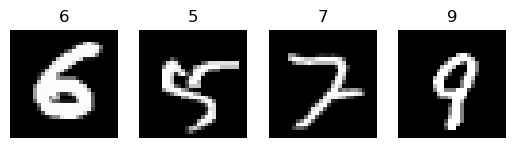

In [11]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(images.shape)
print(labels.shape)
import matplotlib.pyplot as plt

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(labels[i].item())
    plt.axis('off')

plt.show()

### 3. Define your neural network architecture

With your data and dataloaders appropriately set, you're ready to define a network architecture. In this homework, we'll ask you to evaluate two different architectures.

For the first (we'll call it `HNet` in this homework), please implement Hinton's 2006 architecture of 7-hidden layers:

```[784 x 1000 x 500 x 250 x 2 x 250 x 500 x 1000 x 784]. ```

For the second, implement your own autoencoder architecture, `MyNet`, again using a bottleneck dimension of 2. As a note, the larger your model, the longer it will take to train. Can you achieve similar performance to the model above using a more condensed model?

**Tips:**
* Try different activation functions (Tanh, Sigmoid, ReLU, etc)
* A sequence of layers can be defined more easily using `nn.Sequential`, see [docs](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential)
* Split your network into an `.encode()` and a `.decode()`, that will be called sequentially in `.forward()`. This will be useful later on when we'll ask to visualize the low-dimensional embeddings ("latent space") produced by the encoder.

In [12]:
class HNet(nn.Module):
    def __init__(self):
        super().__init__()
        ### Implement a version of Hinton's 2006 Autoencoder,
        ### using a bottleneck latent dimension of 2
        self.encoder = nn.Sequential(
            # implement the encoder architecture
                nn.Linear(784, 1000),
                nn.ReLU(),
                nn.Linear(1000, 500),
                nn.ReLU(),         
                nn.Linear(500, 250),   
                nn.ReLU(),         
                nn.Linear(250, 2)  
        )

        self.decoder = nn.Sequential(
            # implement the decoder architecture
                nn.Linear(2, 250),
                nn.ReLU(),
                nn.Linear(250, 500),
                nn.ReLU(),         
                nn.Linear(500, 1000),   
                nn.ReLU(),         
                nn.Linear(1000, 784)
        )

    def encode(self, x):
        ### Implement the encoder forward pass
        return self.encoder(x)

    def decode(self, x):
        ### Implement the decoder forward pass
        return self.decoder(x)

    def forward(self, x):
        ### Implement the complete forward pass
        if x.dim() == 4:
            x = x.view(x.size(0), -1)
        z = self.encode(x)
        recon = self.decode(z)
        # Reshape to image shape: [B,1,28,28]
        recon_img = recon.view(x.size(0), 1, 28, 28)
        return recon_img, z

In [13]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        ### Fill in your network architecture here
        ### also using a bottleneck latent dimension of 2
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

        self.decoder = nn.Sequential(
            # implement your decoder architecture
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def encode(self, x):
        ### Implement the encoder forward pass
        return self.encoder(x)

    def decode(self, x):
        ### Implement the decoder forward pass
        return self.decoder(x)

    def forward(self, x):
        ### Implement the complete forward pass
        if x.dim() == 4:
            x = x.view(x.size(0), -1)
        z = self.encode(x)
        out = self.decode(z)
        out = out.view(x.size(0), 1, 28, 28)
        return out, z

> **Q3.1) What activation functions did you use, and why?**
    I used ReLU activation functions in the hidden layers of both the encoder and decoder because ReLU helps avoid vanishing gradients and improves training stability. For the final output layer, I used a Sigmoid activation to constrain the reconstructed pixel values to the range [0,1], matching the normalized MNIST input data.
...

### 4. Write your own training function

Write your own training function that takes your **model**, an **optimizer**, and a **training criterion**, and iterates over the **training set**.
* *Hint*: Because an autoencoder is a form of unsupervised learning, we won't need to use the labels like in the MNIST classification example. Keep in mind the format of the images and whether they're compatible with feed-forward networks.
* For each epoch, print and record (in an array or list) the training loss.
* You may want to save the model and its weights on file at regular intervals ([checkpointing](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference)). In order to visualize the autoencoder's learning process, we suggest to save at least three timepoints: early, intermediate, and final (for instance, if your model converges after 60 epochs, save your model at 5 epochs, 30 epochs, and 60 epochs).

A few useful tips:
- Feel free to look at the MNIST classification notebook from previous recitations and use it as a template.
- Printing out the intermediate variables and their shape at each step can be helpful for debugging.

In [14]:
import os

In [15]:
def train(train_loader, model, optimizer, criterion,
          n_epochs=10, **kwargs):

    # Where to run computations (CPU or GPU).
    device = kwargs.get("device", torch.device("cpu"))
    model.to(device)
    
    # Optional checkpointing settings (use kwargs to keep call sites simple).
    checkpoint_epochs = kwargs.get("checkpoint_epochs", [])
    checkpoint_dir = kwargs.get("checkpoint_dir", "./checkpoints")
    model_name = kwargs.get("model_name", model.__class__.__name__)
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Lists to store per-epoch metrics for plotting later.
    losses = []
    checkpoints = []

    # Loop over epochs (one full pass through the training data each time).
    for epoch in range(1, n_epochs + 1):
        # Set the model to training mode.
        model.train()
        running_loss = 0.0
        n_batches = 0

        # Loop over mini-batches from the DataLoader.
        for batch in train_loader:
            # train_loader may yield (imgs, labels) or imgs directly.
            if isinstance(batch, (list, tuple)) and len(batch) >= 1:
                imgs = batch[0]
            else:
                imgs = batch

            # Move data to the selected device (CPU/GPU).
            imgs = imgs.to(device)

            # If you have a helper prepare_batch function you can still use it,
            # otherwise the line below is optional and can be omitted.
            # imgs = prepare_batch(imgs, model)

            # 1) Clear old gradients from the previous step.
            optimizer.zero_grad()

            # 2) Forward pass: model may return recon or (recon, z)
            out = model(imgs)
            if isinstance(out, (list, tuple)):
                recon = out[0]
            else:
                recon = out

            # Ensure recon and imgs have compatible shapes for the loss:
            # common cases: imgs [B,1,28,28] and recon [B,1,28,28] OR recon [B,784]
            if recon.dim() == 2 and imgs.dim() == 4:
                # flatten imgs to [B, 784] if recon is flat
                target = imgs.view(imgs.size(0), -1)
            elif recon.dim() == 4 and imgs.dim() == 2:
                # flatten recon (rare) to match imgs
                recon = recon.view(recon.size(0), -1)
                target = imgs
            else:
                target = imgs

            # 3) Compute loss (reconstruction)
            loss = criterion(recon, target)

            # 4) Backward pass and update
            loss.backward()
            optimizer.step()

            # Accumulate loss for reporting.
            running_loss += loss.item()
            n_batches += 1

        # Average loss over the epoch.
        epoch_loss = running_loss / max(1, n_batches)
        losses.append(epoch_loss)

        # Optionally save checkpoints at requested epochs.
        if epoch in checkpoint_epochs:
            ckpt_path = os.path.join(
                checkpoint_dir, f"{model_name}_epoch{epoch}.pt")
            torch.save(model.state_dict(), ckpt_path)
            checkpoints.append(ckpt_path)

        # Print epoch summary.
        print(f"Epoch {epoch}/{n_epochs} - loss: {epoch_loss:.6f}")

    return losses, checkpoints

### 5. Define your optimization and evaluation criterion

Define an optimizer and criterion (loss function) for your neural network training. To setup your optimizer, you'll have to instantiate your models above, and choose a learning rate. Try a few different optimizers and learning rates to get a sense of what will train within a reasonable timeframe (if your deep network isn't too deep, reaching convergence shouldn't take more than 5-10 minutes with the right choice of learning rate and optimizer).

> **Q5.1) What loss function is suited to this problem?**
    MSELoss is suitable because this is a reconstruction task where the goal is to minimize the pixel-wise difference between the original image and the reconstructed image. MSE assumes errors follow Gaussian distribution (Gaussian noise). Since the task is essentially a regression problem, MSE provides a natural measure of reconstruction error.
...

> **Q5.2) Try a few optimizers, what seemed to work best?**
    Adam. 
...

> **Q5.3) What's the effect of choosing different batch sizes?**
    Smaller batch sizes introduce more noise in the gradient estimates, which can slow down convergence but often improve generalization because the noise helps the model escape sharp local minima.
    Larger batch sizes produce more stable and accurate gradient estimates, leading to faster and smoother training, but they may result in poorer generalization and require more memory.
...

In [16]:
### Instantiate your model HNet, MyNet
model = HNet()
### Define your loss function (training criterion)
criterion = nn.MSELoss()
### Choose your optimizer
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### 6. Run your training loop

It's a great idea to monitor the early epochs of your training ("babysit your training") to keep an eye on learning. Does the learning rate seem too high? too low?

(**Hint: it's recommended that you just test a single epoch at a time while you write your training function, to debug and make sure everything is working appropriately.**)

In [17]:
### Set a number of training epochs and train your model.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
losses, ckpts = train(
    train_loader,
    model,
    optimizer,
    criterion,
    n_epochs=100,
    device=device,
    checkpoint_epochs=[],   # 或 [1] 保存一次权重便于检查
    checkpoint_dir="./checkpoints",
)

/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 1/100 - loss: 0.540011


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 2/100 - loss: 0.438069


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 3/100 - loss: 0.416483


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 4/100 - loss: 0.406424


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 5/100 - loss: 0.396413


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 6/100 - loss: 0.395763


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 7/100 - loss: 0.385744


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 8/100 - loss: 0.381156


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 9/100 - loss: 0.380186


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 10/100 - loss: 0.377127


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 11/100 - loss: 0.373781


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 12/100 - loss: 0.374258


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 13/100 - loss: 0.373141


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 14/100 - loss: 0.385344


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 15/100 - loss: 0.368226


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 16/100 - loss: 0.369709


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 17/100 - loss: 0.375717


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 18/100 - loss: 0.373817


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 19/100 - loss: 0.366514


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 20/100 - loss: 0.365835


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 21/100 - loss: 0.367820


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 22/100 - loss: 0.364257


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 23/100 - loss: 0.365504


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 24/100 - loss: 0.362051


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 25/100 - loss: 0.363483


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 26/100 - loss: 0.360991


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 27/100 - loss: 0.360062


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 28/100 - loss: 0.358777


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 29/100 - loss: 0.359796


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 30/100 - loss: 0.363670


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 31/100 - loss: 0.362430


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 32/100 - loss: 0.362647


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 33/100 - loss: 0.359024


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 34/100 - loss: 0.356481


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 35/100 - loss: 0.357427


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 36/100 - loss: 0.354544


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 37/100 - loss: 0.354875


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 38/100 - loss: 0.354842


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 39/100 - loss: 0.354843


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 40/100 - loss: 0.356081


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 41/100 - loss: 0.354384


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 42/100 - loss: 0.353901


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 43/100 - loss: 0.352949


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 44/100 - loss: 0.355155


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 45/100 - loss: 0.351189


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 46/100 - loss: 0.349288


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 47/100 - loss: 0.349591


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 48/100 - loss: 0.347174


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 49/100 - loss: 0.348087


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 50/100 - loss: 0.351980


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 51/100 - loss: 0.351226


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 52/100 - loss: 0.353543


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 53/100 - loss: 0.355921


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 54/100 - loss: 0.352874


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 55/100 - loss: 0.351565


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 56/100 - loss: 0.351163


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 57/100 - loss: 0.350048


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 58/100 - loss: 0.350805


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 59/100 - loss: 0.346269


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 60/100 - loss: 0.347097


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 61/100 - loss: 0.347408


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 62/100 - loss: 0.349505


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 63/100 - loss: 0.348472


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 64/100 - loss: 0.346502


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 65/100 - loss: 0.347156


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 66/100 - loss: 0.346254


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 67/100 - loss: 0.353732


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 68/100 - loss: 0.351058


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 69/100 - loss: 0.345403


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 70/100 - loss: 0.343003


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 71/100 - loss: 0.348229


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 72/100 - loss: 0.346840


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 73/100 - loss: 0.346001


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 74/100 - loss: 0.347902


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 75/100 - loss: 0.342473


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 76/100 - loss: 0.359539


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 77/100 - loss: 0.349609


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 78/100 - loss: 0.345167


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 79/100 - loss: 0.345303


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 80/100 - loss: 0.344173


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 81/100 - loss: 0.342339


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 82/100 - loss: 0.342506


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 83/100 - loss: 0.343485


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 84/100 - loss: 0.342200


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 85/100 - loss: 0.340208


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 86/100 - loss: 0.341724


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 87/100 - loss: 0.340633


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 88/100 - loss: 0.341630


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 89/100 - loss: 0.341662


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 90/100 - loss: 0.339707


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 91/100 - loss: 0.338621


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 92/100 - loss: 0.345109


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 93/100 - loss: 0.347289


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 94/100 - loss: 0.342296


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 95/100 - loss: 0.340626


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 96/100 - loss: 0.344866


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 97/100 - loss: 0.350264


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 98/100 - loss: 0.345378


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 99/100 - loss: 0.343100


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

Epoch 100/100 - loss: 0.343500


In your training loop, we requested that you store your training loss for each epoch. Using Matplotlib, please plot your training loss as a function of epochs.

In [18]:
# 如果 losses 在当前 scope 存在，打印它
try:
    print("len(losses) =", len(losses))
    print("losses:", losses)
except NameError:
    print("losses 变量不存在（尚未被定义）")

len(losses) = 100
losses: [0.5400106772176747, 0.4380689416485809, 0.4164827546712432, 0.4064244891026381, 0.3964131116104533, 0.39576348452679894, 0.3857436501649397, 0.3811557178558317, 0.3801859635025708, 0.3771272430669016, 0.37378123586874273, 0.37425849458047833, 0.37314144088261164, 0.38534426352362644, 0.3682261007045632, 0.3697094882347945, 0.3757169787436406, 0.37381712949352225, 0.36651444288967516, 0.36583536348617407, 0.36782019154857726, 0.36425671464344583, 0.36550395282855164, 0.3620505038100773, 0.3634825223671602, 0.3609909447652699, 0.36006185800027746, 0.35877684527622866, 0.3597955593803544, 0.363670486186359, 0.36243032112812945, 0.36264703866006975, 0.35902407218906673, 0.3564811517943197, 0.35742738283773473, 0.3545440020464631, 0.35487472051496444, 0.3548418875696308, 0.3548433453416519, 0.35608131328879644, 0.35438392468606994, 0.3539009514902192, 0.3529491162122185, 0.35515465379269645, 0.3511889610590457, 0.34928794348163644, 0.34959127126472084, 0.347174144

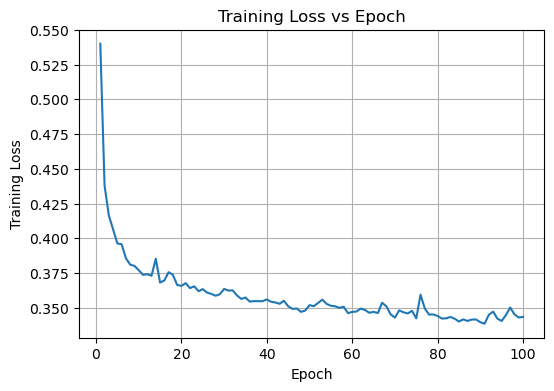

In [19]:
### Plot loss curve using Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(range(1, len(losses)+1), losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epoch")
plt.grid(True)
plt.show()

> **Q6.1)  How do you know when your network is done training?**

...



Another way to check if your models (`HNet` and `MyNet`) are well trained is to plot a few image reconstructions to see how well your models do.

In [21]:
# extract 6 figures from training DataLoader
mini_batch, _ = next(iter(train_loader))
n_examples = min(6, mini_batch.shape[0])
examples = mini_batch[:n_examples]

with torch.no_grad():
    reconstr_examples, _ = model(
        examples.view(n_examples, -1).to(device))

comparison = torch.cat([
    examples,
    reconstr_examples.view(-1, 1, 28, 28).cpu()
])

save_image(comparison, 'training_reconstruction.png', nrow=n_examples)

/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

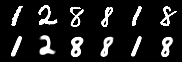

In [22]:
Image('training_reconstruction.png', width=300)

> **Q6.2) What does `torch.no_grad()` do?**

...

### 7. Visualize the learning process

We'll next try to visualize how well the model is learning on the **test set**. To do this, we'll first visualize the "learning process" by viewing reconstruction at various stages.

* Using your checkpoints saved during training, plot a batch of images from the test set and their corresponding reconstructions based on each of your saved models over time. You should see the quality of the reconstructions improving over time.
* To visualize images, you can use the helper functions provided below.


/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/zhwu_cecilia/miniconda3/envs/homework/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvis

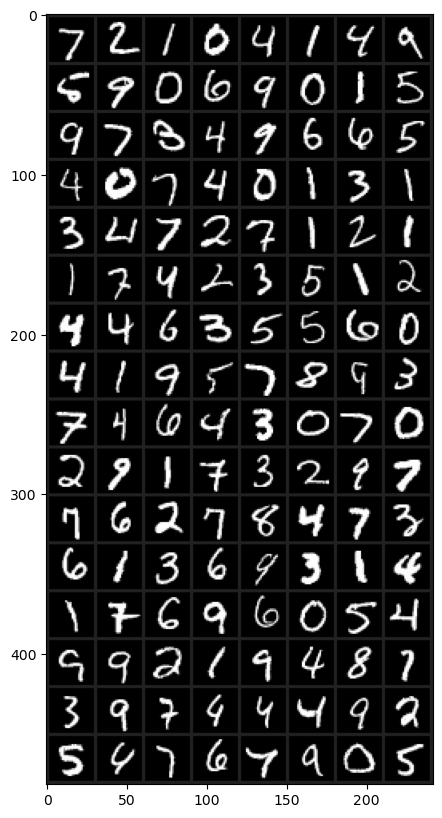

In [23]:
### Helper Functions for Plotting Multiple Images

def imshow(inp,
           figsize=(10,10),
           mean=0.1307, # for MNIST train
           std=0.3081, # for MNIST train
           title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().detach()
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=figsize)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def reconstructions_from_batch(model, batch):
    batch = batch.view(-1, 28 * 28).to(device)
    reconstruction = model(batch)
    return reconstruction.reshape(batch.shape[0],1,28,28)

# Get a batch of training data
batch, classes = next(iter(test_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(batch)
imshow(out)

In [ ]:
### Iterate over checkpoints and plot reconstruction
### figures from the test set.

### 8. Visualize the latent space

As discussed in class, the first half of an autoencoder (the *encoder*) maps the original input into a lower-dimensional latent space.
* Just as shown in Hinton and Salakhutdinov, run your test set of 10,000 MNIST digits through the **encoding layer** of one of the trained networks above. Each sample should readily map to a 2-dimension point. To do this, it will be helpful to fill out a new function, **encode** below, that takes in your trained model and the `test_dataloader` to produce 2d latent embeddings and their corresponding labels.
* Plot each point in these two dimensions, and color each point in this **latent space** by their known **labels**.


In [24]:
### Write a helper function to grab examples from the test_loader to generate
### pairs of embeddings and their associated labels

def get_encodings(model, device, test_loader):
  #### Fill this in! ####
  latent_embeddings = None # get the latent embeddings from the bottleneck
  labels = None # each pair of coordinates has an associated label
  return latent_embeddings, labels

### Plot 2D latent space representation color-coded according to their true labels

> **Q8.1) Does your autoencoder separate out different classes effectively? What classes seem to be closer and what classes are farther apart in this latent space?**

...

## Optional (advanced): Train an autoencoder on CelebA Faces

Real-world images tend to be far more complex than digits from MNIST. As an optional exercise for your own interest, or for students looking for more experience, we'll investigate a subset of CelebA below.

We provide the images in a .zip file (`faces.zip`) in the class's Google Drive folder, which contains a "train" and "test" set of 80k and 10k images, respectively. Although these are color, RGB images, below we've set up the datasets to convert these to grayscale with precomputed means (0.4401) and stds (0.2407), for convenience and easier compute.

In [ ]:
### Download faces.zip and unzip it into bmi219_downloads/

In [ ]:
# preprocessing = transforms.Compose([
#     transforms.Grayscale(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4401,), (0.2407,)),
# ])

# train_dataset = datasets.ImageFolder(
#     'bmi212_downloads/Faces/train',
#     transform=preprocessing)

# test_dataset = datasets.ImageFolder(
#     'bmi212_downloads/Faces/test',
#     transform=preprocessing)

As above, you'll want to:

1. set up your dataloaders and visualize some of the images
2. set up your autoencoder network architecture
3. define your training criterion and optimizer
4. train your network
    
In this case, you should be able to reuse much of your code from above. Consider a few questions:

1. How well do complex images like faces work with a latent dimension of 2?
2. Do reconstructions look better with a larger bottleneck?
3. What kind of features are poorly reconstructed? What happens to sunglasses, hats, and hands?
4. Try sampling the 2-d latent space close to existing examples (by adding some noise...) or randomly. What do the generated images look like?